In [14]:
import xarray as xr
import numpy as np
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob
from matplotlib.colors import LogNorm
import matplotlib.patches as patches

In [2]:
# Load Eulerian data
uvel_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel_centered.zarr')
vvel_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel_centered.zarr')

uvel_merged = uvel_merged.isel(time=slice(1,110)).isel(k=0)

vvel_merged = vvel_merged.isel(time=slice(1,110)).isel(k=0)

uvel_merged = uvel_merged.drop_vars('time')
vvel_merged = vvel_merged.drop_vars('time')
grid = Grid(uvel_merged, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

In [3]:
def lanczos(x, a):
    return np.sinc(x/a)



In [4]:
fnames = sorted(glob(f'/swot/SUM01/spencer/36hr_timeseries/*.zarr'))
nofiles = len(fnames)
for fileno in range(0,49):#nofiles
        print('/swot/SUM01/spencer/36hr_timeseries/rechunked_' + str(6048+fileno*144) +'.zarr')
        ds = xr.open_zarr('/swot/SUM01/spencer/36hr_timeseries/rechunked_' + str(6048+fileno*144) +'.zarr')
        ds = ds.isel(niter=slice(1,74))
        ds['time'] = ds['niter']*3600/144
        ds = ds.assign_coords({"time": ds.time})
        ds = ds.swap_dims({"niter": "time"})
        ds = ds.where(ds.u!=-999)
        window_width=20
        weight = xr.DataArray(lanczos(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
        windowed_u = ds.u.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
        windowed_v = ds.v.rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
        u_piece = windowed_u.sel(time=0).isel(z0=3)
        v_piece = windowed_v.sel(time=0).isel(z0=3)
        u_piece2 = ds.u.sel(time=0).isel(z0=3)
        v_piece2 = ds.v.sel(time=0).isel(z0=3)
        u_piece["time"] = fileno*3600
        v_piece["time"] = fileno*3600
        u_piece2["time"] = fileno*3600
        v_piece2["time"] = fileno*3600
        if fileno==0:
            u_filtered = u_piece
            v_filtered = v_piece
            u_unfiltered = u_piece2
            v_unfiltered = v_piece2
        else:
            u_filtered = xr.concat([u_filtered,u_piece],dim='time')
            v_filtered = xr.concat([v_filtered,v_piece],dim='time')
            u_unfiltered = xr.concat([u_unfiltered,u_piece2],dim='time')
            v_unfiltered = xr.concat([v_unfiltered,v_piece2],dim='time')

/swot/SUM01/spencer/36hr_timeseries/rechunked_6048.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6192.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6336.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6480.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6624.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6768.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_6912.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7056.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7200.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7344.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7488.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7632.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7776.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_7920.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8064.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8208.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_8352.zarr
/swot/SUM01/spencer/36hr_timeseries/rechunked_84

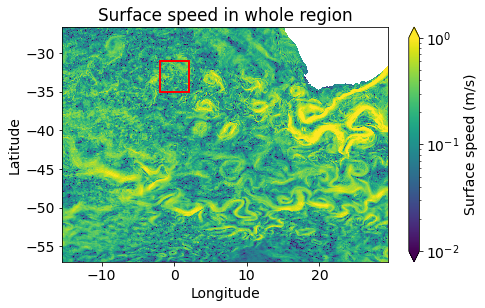

In [113]:
plt.figure(figsize=(7,4.5))
from matplotlib.colors import LogNorm
(np.sqrt(u_unfiltered**2+v_unfiltered**2)).where(np.sqrt(u_filtered**2+v_filtered**2)>0).isel(time=0).rename('Surface speed (m/s)').plot.pcolormesh(
        x='x0',y='y0',norm=LogNorm(),vmin=10**-2,vmax=1,rasterized=True,cbar_kwargs={'extend':'both'})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('')

ax=plt.gca()
rect = patches.Rectangle((-2, -35), 4, 4, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)
plt.title('Surface speed in whole region')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("unfiltered.png")

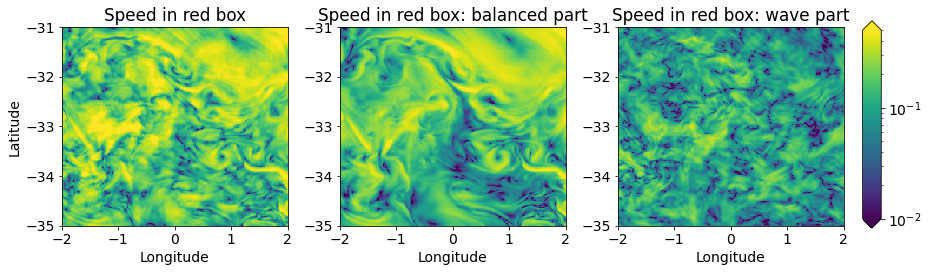

In [115]:
plt.figure(figsize=(13,4))
from matplotlib.colors import LogNorm
plt.subplot(131)
(np.sqrt(u_unfiltered**2+v_unfiltered**2)).where(np.sqrt(u_filtered**2+v_filtered**2)>0).isel(time=0).rename('Surface speed (m/s)').plot.pcolormesh(
        x='x0',y='y0',norm=LogNorm(),vmin=10**-2,vmax=0.5,rasterized=True,add_colorbar=False)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Speed in red box')
plt.xlim(-2,2)
plt.ylim(-35,-31)

plt.subplot(132)
(np.sqrt(u_filtered**2+v_filtered**2)).where(np.sqrt(u_filtered**2+v_filtered**2)>0).isel(time=0).rename('Surface speed (m/s)').plot.pcolormesh(
        x='x0',y='y0',norm=LogNorm(),vmin=10**-2,vmax=0.5,rasterized=True,add_colorbar=False)
plt.xlabel('Longitude')
plt.ylabel('')
plt.title('Speed in red box: balanced part')
plt.xlim(-2,2)
plt.ylim(-35,-31)

plt.subplot(133)
cs = (np.sqrt((u_unfiltered-u_filtered)**2+(v_unfiltered-v_filtered)**2)).where(np.sqrt(u_filtered**2+v_filtered**2)>0).isel(time=0).rename('Surface speed (m/s)').plot.pcolormesh(
        x='x0',y='y0',norm=LogNorm(),vmin=10**-2,vmax=0.5,rasterized=True,add_colorbar=False)
plt.xlabel('Longitude')
plt.ylabel('')
plt.title('Speed in red box: wave part')
plt.xlim(-2,2)
plt.ylim(-35,-31)

fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax,extend='both')
fig = plt.gcf()
fig.savefig("unfiltered_zoom.png")

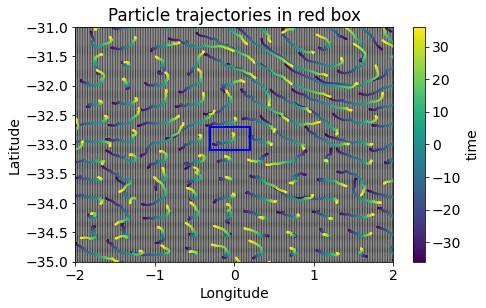

In [110]:
plt.figure(figsize=(7,4.5))
ds.isel(z0=3,y0=slice(500,2000),x0=slice(0,1000)).plot.scatter(x='x0', y='y0',hue='z0',cmap='binary', s=0.1,vmax=-0.4,vmin=-10,add_guide=False)
ds.isel(x0=np.arange(0,2160,20),y0=np.arange(0,2160,20),z0=3).assign_coords(time=ds.time/3600).plot.scatter(x='x', y='y', hue='time',cmap='viridis', s=1.6)
plt.xlim(-2,2)
plt.ylim(-35,-31)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Particle trajectories in red box')

ax=plt.gca()
rect = patches.Rectangle((-0.3, -33.1), 0.5, 0.4, linewidth=2, edgecolor='b', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.tight_layout()
fig = plt.gcf()
fig.savefig("particle_traj.png")

In [107]:
ds.isel(x0=np.arange(0,2160,20),y0=np.arange(0,2160,20),z0=3)

<xarray.Dataset>
Dimensions:  (time: 73, x0: 108, y0: 108)
Coordinates:
    niter    (time) int64 -5184 -5040 -4896 -4752 -4608 ... 4752 4896 5040 5184
  * x0       (x0) float64 -15.49 -15.07 -14.66 -14.24 ... 28.26 28.68 29.09
  * y0       (y0) float64 -57.0 -56.78 -56.56 -56.33 ... -27.67 -27.33 -26.98
    z0       float64 -0.5
  * time     (time) float64 -1.296e+05 -1.26e+05 ... 1.26e+05 1.296e+05
Data variables:
    eta      (time, x0, y0) float64 dask.array<chunksize=(73, 9, 9), meta=np.ndarray>
    s        (time, x0, y0) float64 dask.array<chunksize=(73, 9, 9), meta=np.ndarray>
    t        (time, x0, y0) float64 dask.array<chunksize=(73, 9, 9), meta=np.ndarray>
    u        (time, x0, y0) float64 dask.array<chunksize=(73, 9, 9), meta=np.ndarray>
    v        (time, x0, y0) float64 dask.array<chunksize=(73, 9, 9), meta=np.ndarray>
    x        (time, x0, y0) float64 dask.array<chunksize=(73, 9, 9), meta=np.ndarray>
    y        (time, x0, y0) float64 dask.array<chunksize=(73, 9, 9), meta=np.ndarray>
    z        (time, x0, y0) float64 dask.array<chunksize=(73, 9, 9), meta=np.ndarray>

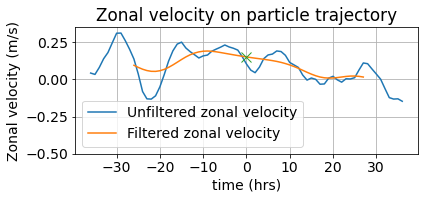

In [103]:
plt.figure(figsize=(6,3))
ds.isel(x0=740,y0=1780,z0=3).assign_coords(time=ds.time/3600).u.plot(label='Unfiltered zonal velocity')
windowed_u.isel(x0=740,y0=1780,z0=3).assign_coords(time=ds.time/3600).plot(label='Filtered zonal velocity')
plt.plot(0,0.14969224,marker='x',markersize=10)
plt.grid()
plt.title('Zonal velocity on particle trajectory')
plt.xlabel('time (hrs)')
plt.ylabel('Zonal velocity (m/s)')
plt.legend()
plt.ylim(-0.5,0.35)
plt.tight_layout()

fig = plt.gcf()
fig.savefig("smoothed_vel.png")

In [96]:
windowed_u.isel(x0=740,y0=1780,z0=3).assign_coords(time=ds.time/3600).sel(time=0).values#.plot.line(x='time')

array(0.14969224)

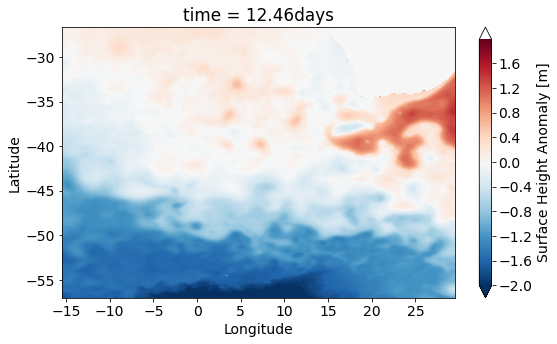

In [6]:
plt.figure(figsize=(8,5))
for tt in range(0,300):
    plt.clf()
    eta_merged.Eta.isel(time=tt).plot.pcolormesh(x='x',y='y',levels=np.arange(-2,2,0.01),rasterized=True,cbar_kwargs={'extend':'both'})
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('time = ' + '{0:.2f}'.format((eta_merged.time.values[tt]-eta_merged.time.values[0])/3600/24)+ 'days')
    plt.tight_layout()
    
    fig = plt.gcf()
    fig.savefig("/home/spencerj/agulhas-offline/movie/eta/fig{:03d}.jpg".format(tt))

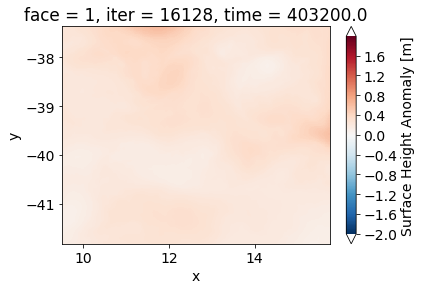

In [17]:
eta_merged.Eta.isel(time=0, i=slice(1200,1500), j=slice(1200,1500)).plot(x='x',y='y',levels=np.arange(-2,2,0.01),cbar_kwargs={'extend':'both'})

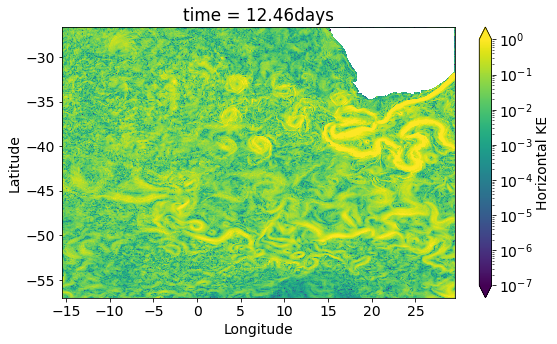

In [7]:
#ffmpeg -r 60 -f image2 -i fig%03d.jpg -vcodec libx264 -crf 25 -pix_fmt yuv420p vel.mp4
plt.figure(figsize=(8,5))
from matplotlib.colors import LogNorm
for tt in range(0,300):
    plt.clf()
    (uvel_merged.U**2+vvel_merged.V**2).where((uvel_merged.U**2+vvel_merged.V**2)>0).isel(time=tt).rename('Horizontal KE').plot.pcolormesh(
        x='x',y='y',norm=LogNorm(),vmin=10**-7,vmax=1,rasterized=True,cbar_kwargs={'extend':'both'})
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('time = ' + '{0:.2f}'.format((eta_merged.time.values[tt]-eta_merged.time.values[0])/3600/24)+ 'days')
    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig("/home/spencerj/agulhas-offline/movie/vel/fig{:03d}.jpg".format(tt))

In [4]:
ds = uvel_merged.merge(vvel_merged)

In [62]:
(eta_merged.y.isel(i=slice(1230,1300), j=slice(1230,1300)).min()).values

array(-41.378414, dtype=float32)

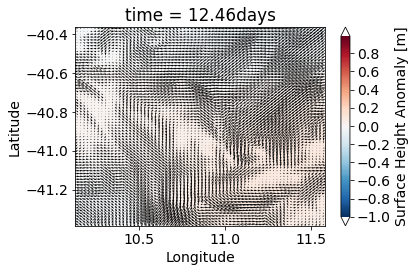

In [53]:
for tt in range(0,300):
    plt.clf()
    eta_merged.Eta.isel(time=tt, i=slice(1230,1300), j=slice(1230,1300)).plot(x='x',y='y',levels=np.arange(-1,1,0.01),cbar_kwargs={'extend':'both'})
    ds.isel(time=tt, i=slice(1230,1300), j=slice(1230,1300)).plot.quiver(x="x", y="y", u="U", v="V",scale=6,scale_units='xy',add_guide=False)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('time = ' + '{0:.2f}'.format((eta_merged.time.values[tt]-eta_merged.time.values[0])/3600/24)+ 'days')
    plt.tight_layout()
    fig = plt.gcf()
    fig.savefig("/home/spencerj/agulhas-offline/movie/fig{:03d}.png".format(tt))

In [8]:
ds = xr.open_zarr('/swot/SUM01/spencer/36hr_timeseries/rechunked_6048.zarr')

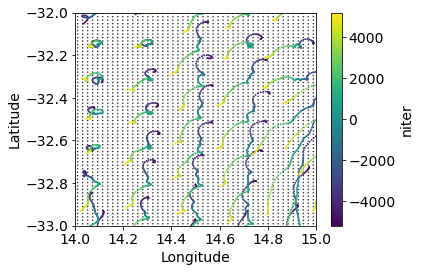

In [18]:
#eta_merged.Eta.where(eta_merged.Eta!=0).isel(time=0).plot.pcolormesh(x='x',y='y',levels=np.arange(-2,2,0.01),rasterized=True,cmap='Greys',add_colorbar=False)
ds.isel(z0=3,y0=slice(500,2000),x0=slice(1000,2000)).plot.scatter(x='x0', y='y0',hue='z0',cmap='binary', s=0.2,vmax=-0.4,vmin=-10,add_guide=False)
ds.isel(x0=np.arange(0,2160,10),y0=np.arange(0,2160,10),z0=3).plot.scatter(x='x', y='y', hue='niter',cmap='viridis', s=0.8)
plt.xlim(14,15)
plt.ylim(-33,-32)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig("/home/spencerj/agulhas-offline/python/particle_traj.png")

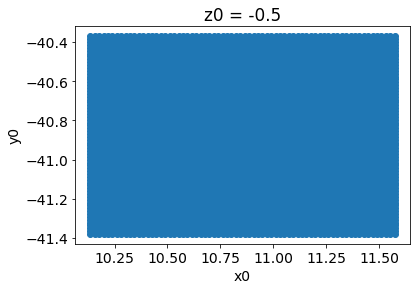

In [9]:
ds.isel(z0=3,y0=slice(1230,1300),x0=slice(1230,1300)).plot.scatter(x='x0', y='y0')

In [7]:
ds.isel(z0=3,y0=slice(1230,1300),x0=slice(1230,1300))

ValueError: Dimensions {'x0', 'y0', 'z0'} do not exist. Expected one or more of Frozen(SortedKeysDict({'i': 2160, 'time': 337, 'j': 2160}))